**Table of contents**<a id='toc0_'></a>    
- [Using minimize from scipy.optimize](#toc1_)    
- [Using PyTorch](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
#from optic.models.devices import mzm, pm

In [2]:

def pm(Ai, u, Vπ):
    try:
        u.shape
    except AttributeError:
        u = np.array([u])

    try:
        if Ai.shape == () and u.shape != ():
            Ai = Ai * np.ones(u.shape)
        else:
            assert (
                Ai.shape == u.shape
            ), "Ai and u need to have the same dimensions"
    except AttributeError:
        Ai = Ai * np.ones(u.shape)

    π = np.pi
    return Ai * np.exp(1j* (u / Vπ) * π)

def mzm(Ai, u, Vπ, Vb):
    try:
        u.shape
    except AttributeError:
        u = np.array([u])

    try:
        if Ai.shape == () and u.shape != ():
            Ai = Ai * np.ones(u.shape)
        else:
            assert (
                Ai.shape == u.shape
            ), "Ai and u need to have the same dimensions"
    except AttributeError:
        Ai = Ai * np.ones(u.shape)

    π = np.pi
    return Ai * np.cos(0.5 / Vπ * (u + Vb) * π)

In [3]:

from scipy.signal import find_peaks
from scipy.constants import c as c0
import numpy as np
import matplotlib.pyplot as plt
#from scipy.signal import welch

π = np.pi

SpS = 64            # Amostras por símbolo
Rs  = 10e9          # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

t = np.arange(0, SpS*1000)*Ta

Vπ = 2
Ai = 1
n_peaks = 11


In [4]:
def get_indx_peaks(log_Pxx, n_peaks):
    indx = find_peaks(log_Pxx, height=(-250,-50))[0]
    discard = (indx.size - n_peaks)
    indx = indx[int(np.floor(discard/2)): -int(np.ceil(discard/2))]

    return indx

In [5]:
def fb_generator(V1,Phase1,Vb1, V2,Phase2,Vb2, V3,Phase3):
    sigTxo_ = Ai
    sigTxo_ = mzm(sigTxo_, V1 * np.cos(2 * π * Rs * t + Phase1), Vπ, Vb1)
    sigTxo_ =  pm(sigTxo_, V3 * np.cos(2 * π * Rs * t + Phase3), Vπ)
    sigTxo_ = mzm(sigTxo_, V2 * np.cos(2 * π * Rs * t + Phase2), Vπ, Vb2)

    return sigTxo_

In [6]:
def plot_fb(sigTxo_, n_peaks):
    # plot frequency combs
    
    # plot psd
    plt.figure();
    Pxx, freqs = plt.psd(sigTxo_, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
    
    log_Pxx = 10*np.log10(Pxx)
    indx = get_indx_peaks(log_Pxx, n_peaks)
    print("Aqui estão os indices: ", indx)
    
    plt.plot(freqs[indx], log_Pxx[indx], 'o')
    plt.legend(loc='lower right');
    #plt.xlim(-16*Rs,16*Rs);
    #plt.ylim(-100,-80);
    
    mean = np.mean(log_Pxx[indx])
    var = np.var(log_Pxx[indx]) 
    plt.plot([freqs[0],freqs[-1]], np.array([1,1])*mean, "--",label = "peaks mean")
    plt.plot([freqs[0],freqs[-1]], np.array([1,1])*(mean+np.sqrt(var)), "--",label = "peaks max")
    plt.plot([freqs[0],freqs[-1]], np.array([1,1])*(mean-np.sqrt(var)), "--",label = "peaks min")
    
    print("Média: %.2f dB" %mean)
    print("Desvio Padrão: %.2f dB" %np.sqrt(var))
    print("Variância: %.2f"%var)
    print("Distância máximo-mínimo: %.2f dB" %(np.max(log_Pxx[indx]) - np.min(log_Pxx[indx])))
    

In [7]:
def plot_sig_and_fb(sig):

    fig, ax = plt.subplots(2,2,figsize = (20,10));
    ax[0,0].plot(t[:SpS*4]*1e9, sig[:SpS*4].real);
    ax[0,1].plot(t[:SpS*4]*1e9, sig[:SpS*4].imag);
    ax[1,0].plot(t[:SpS*4]*1e9, abs(sig[:SpS*4])**2);
    Pxx, freqs = ax[1,1].psd(sig, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')

    #(freqs, Pxx) =  welch(sig, Fa, nperseg=64*1024)
    log_Pxx = 10*np.log10(Pxx)
    #ax[1,1].plot(freqs, log_Pxx)
    
    indx = get_indx_peaks(log_Pxx, n_peaks)
    
    ax[1,1].plot(freqs[indx], log_Pxx[indx], 'o')
    ax[1,1].legend(loc='lower right');
    #ax[1,1].xlim(-16*Rs,16*Rs);
    #ax[1,1].ylim(-100,-80);
    
    mean = np.mean(log_Pxx[indx])
    var = np.var(log_Pxx[indx])
    ax[1,1].plot([freqs[0],freqs[-1]], np.array([1,1])*mean, "--",label = "peaks mean")
    ax[1,1].plot([freqs[0],freqs[-1]], np.array([1,1])*(mean+np.sqrt(var)), "--",label = "peaks max")
    ax[1,1].plot([freqs[0],freqs[-1]], np.array([1,1])*(mean-np.sqrt(var)), "--",label = "peaks min")
    
    print("Média: %.2f dB" %mean)
    print("Desvio Padrão: %.2f dB" %np.sqrt(var))
    print("Variância: %.2f"%var)
    print("Distância máximo-mínimo: %.2f dB" %(np.max(log_Pxx[indx]) - np.min(log_Pxx[indx])))
    
    ax[0,0].grid()
    ax[0,1].grid()
    ax[1,0].grid()
    #ax[1,1].grid()


Média: -101.90 dB
Desvio Padrão: 10.42 dB
Variância: 108.48
Distância máximo-mínimo: 31.81 dB


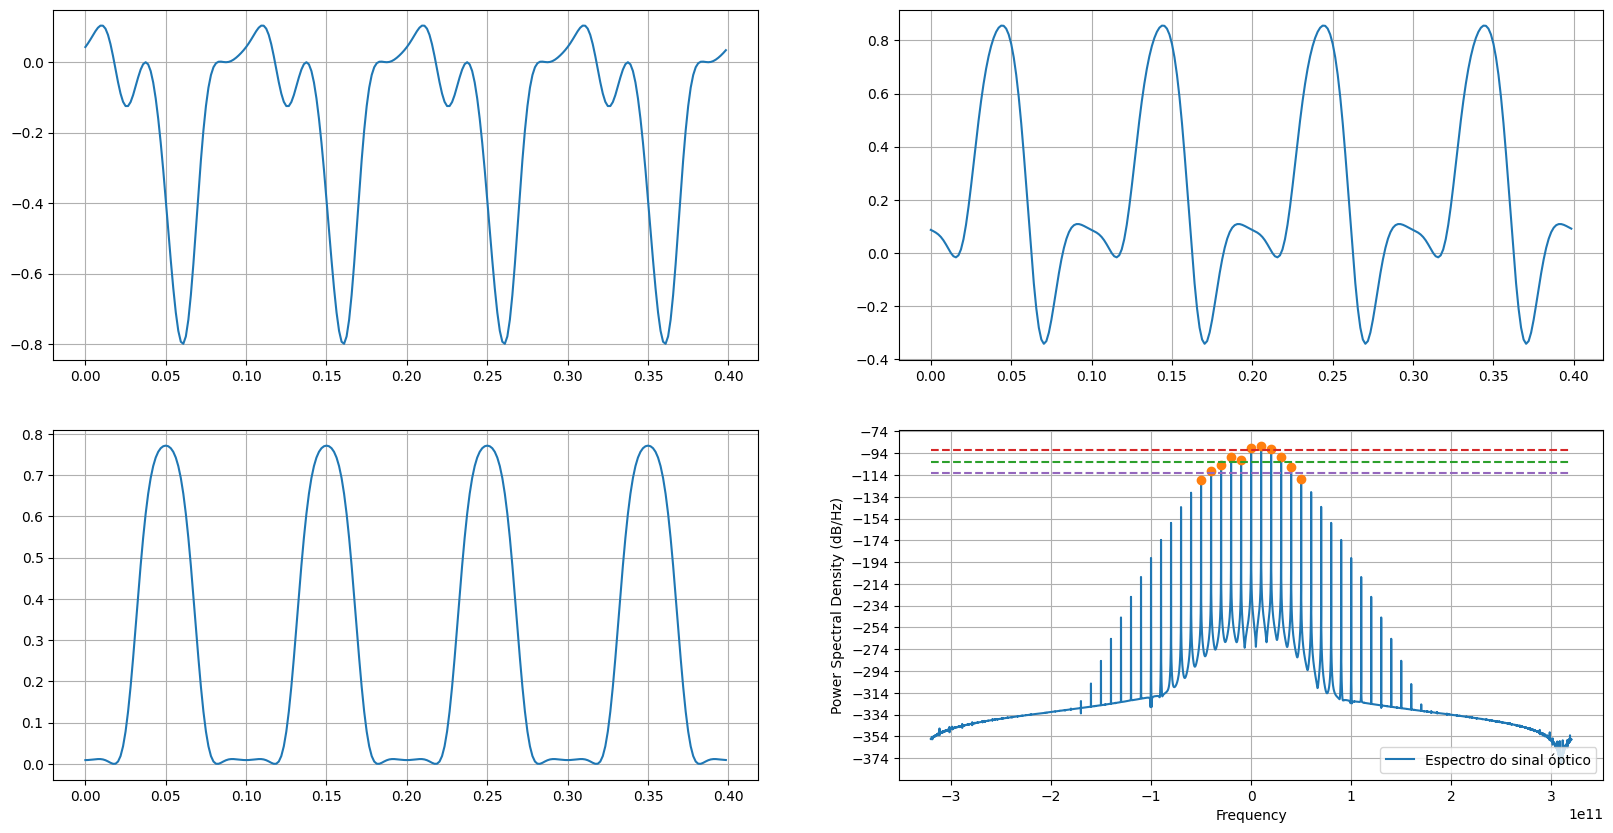

In [8]:
initial_guess = [1, 2*π, π/2, 1, 2*π, 1.5*π, 1, π/4]
sig = fb_generator(*initial_guess)
plot_sig_and_fb(sig)

# <a id='toc1_'></a>[Using minimize from scipy.optimize](#toc0_)

In [23]:
from scipy.optimize import minimize

# Função objetivo a ser minimizada
def objective_function(params):
    
    sigTxo_ = fb_generator(*params)
    
    # Calcular a intensidade dos picos e a função objetivo
    #fig = plt.figure()
    #fig.set_visible(False)
    Pxx, _ = plt.psd(sigTxo_, Fs=Fa, NFFT=16 * 1024, sides='twosided')
    #plt.close()
    log_Pxx = 10*np.log10(Pxx)
    indx = get_indx_peaks(log_Pxx, n_peaks)
    
    log_Pxx_peaks = log_Pxx[indx]
    
    intensity = np.mean(log_Pxx_peaks)
    var = np.var(log_Pxx_peaks)
    desvio = np.sqrt(var)
    min_max_dist = np.max(log_Pxx_peaks) - np.min(log_Pxx_peaks)

    target_desvio = 0
    target_var = 0
    target_min_max_dist = 0
    
    # Objetivo: minimizar a diferença entre a intensidade atual e a média desejada
    #return (desvio - target_desvio) ** 2  # Pode usar outras funções de penalização
    return (var - target_var)**2
    #return (min_max_dist - target_min_max_dist)**2

Configurações otimizadas:
V1: 2.83 V
Phase1: 6.08 rad
Vb1: 3.43 V
V2: 2.83 V
Phase2: 6.08 rad
Vb2: 4.57 V
V3: 1.06 V
Phase3: 0.28 rad



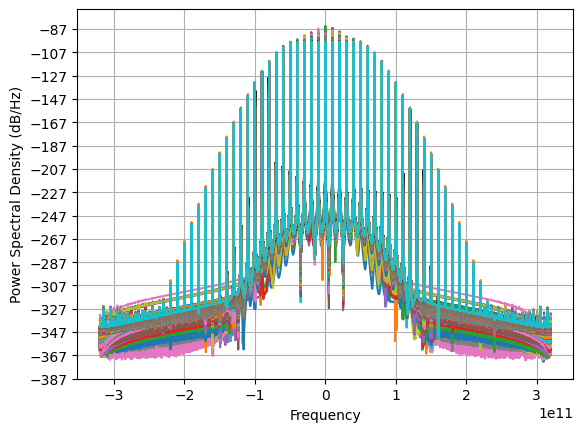

In [24]:
# Chute inicial para as configurações dos moduladores (amplitude e fase)
initial_guess = [1, 2*π, π/2, 1, 2*π, 1.5*π, 1, π/4]

V_min = 0
V_max = 3
Phase_min = 0
Phase_max = 2*π
Vb_min = -4*Vπ
Vb_max = 4*Vπ
bounds = [(V_min,V_max),(Phase_min, Phase_max),(Vb_min,Vb_max),
          (V_min,V_max),(Phase_min, Phase_max),(Vb_min,Vb_max),
          (V_min,V_max),(Phase_min, Phase_max)]

# Realizar a otimização
method = ["Nelder-Mead", "L-BFGS-B", "TNC", "SLSQP", "Powell", "trust-constr", "COBYLA"]
result = minimize(objective_function, initial_guess, method=method[6],bounds = bounds)
optimized_params = result.x

V1, Phase1,  Vb1, V2, Phase2, Vb2, V3, Phase3 = optimized_params

# Exibir as configurações otimizadas
print("Configurações otimizadas:")
print(f"V1: {V1:.2f} V")
print(f"Phase1: {Phase1:.2f} rad")
print(f"Vb1: {Vb1:.2f} V")
print(f"V2: {V2:.2f} V")
print(f"Phase2: {Phase2:.2f} rad")
print(f"Vb2: {Vb2:.2f} V")
print(f"V3: {V3:.2f} V")
print(f"Phase3: {Phase3:.2f} rad\n")

n_peaks = 11
sigTxo_ = fb_generator(*optimized_params)

Média: -98.02 dB
Desvio Padrão: 0.07 dB
Variância: 0.00
Distância máximo-mínimo: 0.21 dB


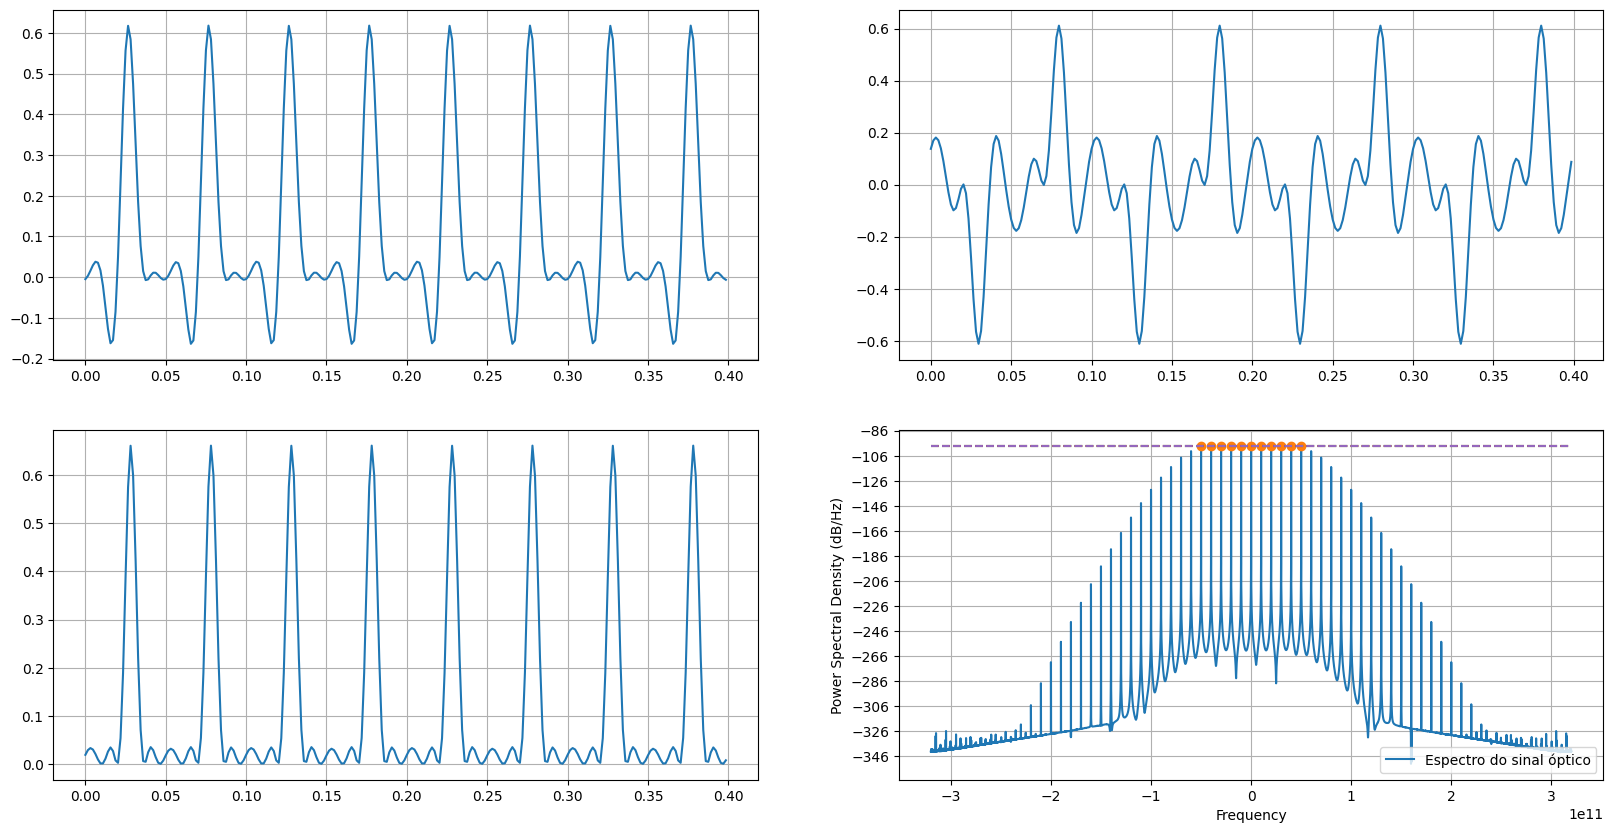

In [26]:
plot_sig_and_fb(sigTxo_)

# <a id='toc2_'></a>[Using PyTorch](#toc0_)

In [9]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand

In [10]:
V_min = 0.1
V_max = 3
Phase_min = 0
Phase_max = 2*π
Vb_min = -4*Vπ
Vb_max = 4*Vπ
bounds = [(V_min,V_max),(Phase_min, Phase_max),(Vb_min,Vb_max),
          (V_min,V_max),(Phase_min, Phase_max),(Vb_min,Vb_max),
          (V_min,V_max),(Phase_min, Phase_max)]

train_nsamples = 10000
test_nsamples = 100
n_peaks = 11

In [11]:
def fb_peaks(V1, Phase1,  Vb1, V2, Phase2, Vb2, V3, Phase3):
    
    #generate the signal (frequency combs)
    fb = fb_generator(V1, Phase1,  Vb1, V2, Phase2, Vb2, V3, Phase3)
    
    # get the signal PSD
    Pxx, _ = plt.psd(fb, Fs=Fa, NFFT=16 * 1024, sides='twosided')
    plt.close()
    log_Pxx = 10*np.log10(Pxx)

    #get n peaks from the signal PSD
    indx = get_indx_peaks(log_Pxx, n_peaks)
    log_Pxx_peaks = log_Pxx[indx]

    return log_Pxx_peaks

In [12]:

# Define your neural network architecture
class FrequencyCombNet(nn.Module):
    def __init__(self):
        super(FrequencyCombNet, self).__init__()
        self.fc1 = nn.Linear(8, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 11)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x[:, :11]

# Define your custom dataset
class FrequencyCombDataset(Dataset):
    def __init__(self, nsamples, bounds):
        self.nsamples = nsamples
        self.bounds = bounds

    def __len__(self):
        return self.nsamples
    
    def __getitem__(self, idx):
        sample = [urand.Uniform(low, high).sample().item() for low, high in self.bounds]
        input_tensor = torch.tensor(sample, dtype=torch.float32)
        output_tensor = torch.tensor(fb_peaks(*sample), dtype=torch.float32)

        '''
        # Ensure all 'output' tensors have the same size by padding or truncating
        desired_size = n_peaks  # Change this to the desired size
        if output_tensor.size(0) < desired_size:
            # Padding if the tensor is smaller than desired_size
            padding_size = desired_size - output_tensor.size(0)
            output_tensor = torch.cat([output_tensor, torch.zeros(padding_size)])
        elif output_tensor.size(0) > desired_size:
            # Truncate if the tensor is larger than desired_size
            output_tensor = output_tensor[:desired_size]
        '''
        return {'input': input_tensor,
                'output': output_tensor}
        



In [13]:

# Create datasets and dataloaders
train_dataset = FrequencyCombDataset(train_nsamples, bounds)
test_dataset = FrequencyCombDataset(test_nsamples, bounds)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#Trying to use CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Runnning in {device}")

# Initialize the model
model = FrequencyCombNet().to(device)

# Função de perda (loss function)
criterion = nn.MSELoss() # Erro quadrático médio (Mean Squared Error)

# Gradiente Descendente Estocástico - SGD (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # taxa de aprendizado - lr (learning rate)

Runnning in cpu


In [14]:
def plot_training_progress(train_losses):
    epochs = len(train_losses)

    plt.plot(range(1, epochs + 1), train_losses,"o--", label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.show()

In [10]:

# Training loop
train_losses = []
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    model.train()
    for batch in train_loader:
        inputs, targets = batch['input'].unsqueeze(1).float().to(device), batch['output'].unsqueeze(1).float().to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Save training losses for plotting
    train_losses.append(loss.item())

    # Print training progress
    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')


Epoch [1/10], Loss: 577.1327514648438


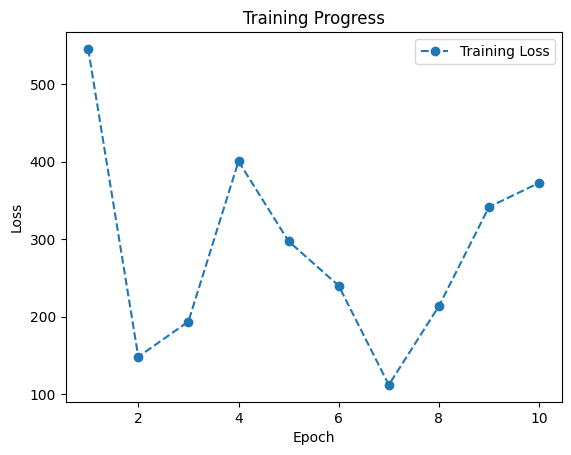

In [ ]:
plot_training_progress(train_losses)

In [ ]:
# Testing loop
model.eval()
with torch.no_grad():
    test_loss = 0.0
    for batch in test_loader:
        inputs, targets = batch['input'].unsqueeze(1).float().to(device), batch['output'].unsqueeze(1).float().to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()

    # Print test loss
    print(f'Test Loss: {test_loss / len(test_loader)}')


Test Loss: 256.68493270874023


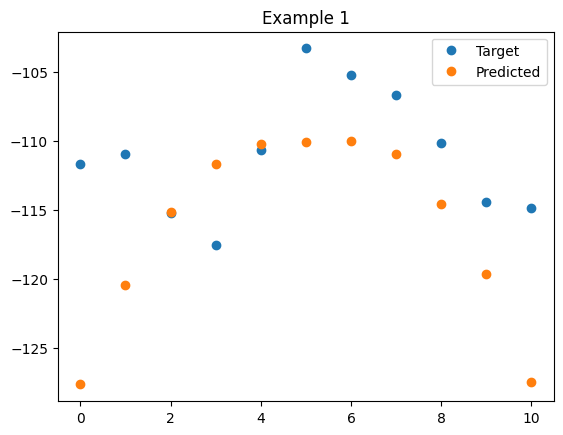

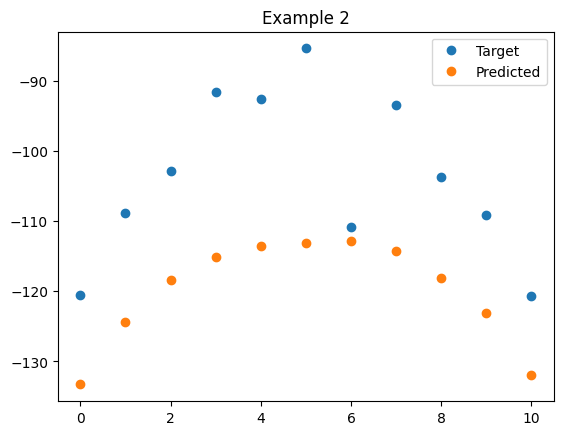

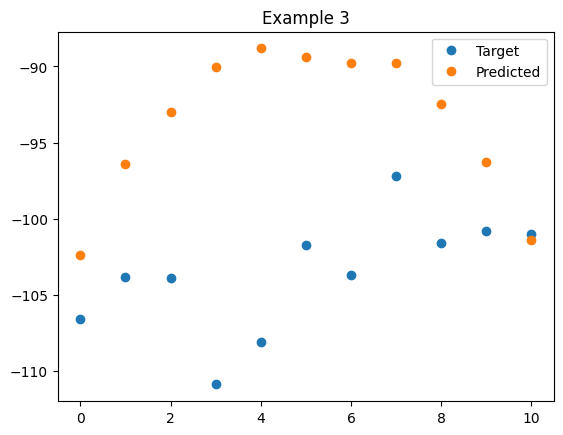

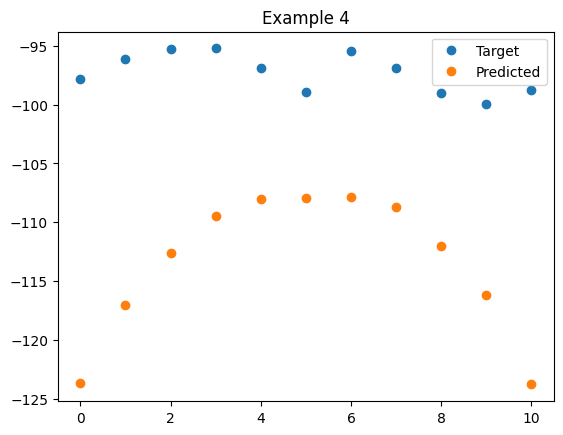

In [ ]:
for i in range(min(10, inputs.shape[0])):  # Loop over the first n examples
    plt.figure()
    plt.plot(targets[i].numpy(),"o", label='Target')
    plt.plot(outputs[i].numpy(),"o", label='Predicted')
    plt.legend()
    plt.title(f'Example {i+1}')
    plt.show()


In [ ]:
'''
# save model
torch.save(net.state_dict(), 'saved_models/model.pth')

# load model
loaded_net = FrequencyCombNet()
loaded_net.load_state_dict(torch.load('saved_models/model.pth'))
loaded_net.eval()
#'''